In [52]:
from setup import *
from utils import *

mi.set_variant("cuda_ad_rgb")

In [53]:
use_checkerboard = True

In [54]:
materials = create_materials(with_fluids=False, fermi_chamber=True)
# components = load_components(materials, fermi_chamber=True)
components = {}
if use_checkerboard:
    c_scale = 7.0
    components.update({
        'checkerboard': {
            'type': 'ply',
            'filename': 'test_scenes/meshes/checkerboard.ply',
            'face_normals': True,
            'bsdf': {
                'type': 'diffuse',
                'id': 'black-bsdf',
                'reflectance': {'type': 'spectrum', 'value': 0.0},
                },
            'to_world': mi.ScalarTransform4f.scale(c_scale),
        }
    })
    # components.update({
    #     'checkerboard_offset': {
    #         'type': 'ply',
    #         'filename': 'test_scenes/meshes/checkerboard_offset.ply',
    #         'face_normals': True,
    #         'bsdf': {
    #             'type': 'diffuse',
    #             'id': 'white-bsdf',
    #             'reflectance': {'type': 'spectrum', 'value': 1.0},
    #             },
    #         'to_world': mi.ScalarTransform4f.scale(c_scale),
    #     }
    # })
    components.update({
        'light': {
            'type': 'constant'
        }
    })

spp = 132
sensor = create_sensor(sensor_number=2, sample_count=spp, fermi_chamber=True)
scene = load_scene(components=components, sensor=sensor)

img = render(scene, denoise=False)
mi.Bitmap(img)

Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [1280, 800],
  srgb_gamma = 0,
  struct = Struct<12>[
    float32 R; // @0, premultiplied alpha
    float32 G; // @4, premultiplied alpha
    float32 B; // @8, premultiplied alpha
  ],
  data = [ 11.7 MiB of image data ]
]

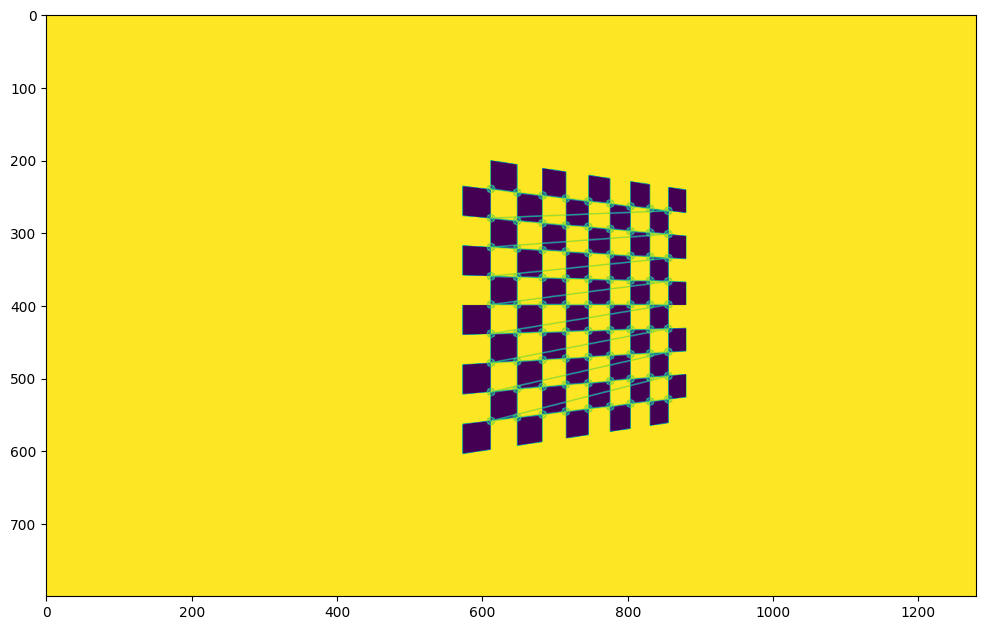

In [55]:
if use_checkerboard:
    x_axis_pts = np.linspace(c_scale*0.8, -c_scale*0.8, 9)
    y_axis_pts = np.linspace(-c_scale*0.8, c_scale*0.8, 9)
    z_axis_pts = np.zeros(9)
    objp = np.vstack([np.dstack((x_axis_pts, np.full(9, y), z_axis_pts)) for y in y_axis_pts]).reshape(81, 3)

    uint_img = np.array(np.average(img, axis=2)*255, dtype=np.uint8) # convert render to single channel uint8 numpy array

    # Find chessboard corners
    ret, corners = cv2.findChessboardCorners(uint_img, (9,9), None)

    # If corners are found, add the object points and image points (after doing subpixel refinement)
    if ret == True:
        imgpoints = cv2.cornerSubPix(uint_img, corners, 
                                    (11,11), # search window
                                    (-1,-1), # zero zone (not used)
                                    (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)) # termination criteria
    else:
        print("Chessboard corners not found!")

    drawn = cv2.drawChessboardCorners(uint_img, (9,9), imgpoints, True)
    plt.figure(figsize=(12, 8))
    plt.imshow(drawn)

else:
    objp = np.array([
        [ 5.3031, -2.397,  0.0],
        [ 2.2381, -5.305,  0.0],
        [ 0.0,     0.0,    0.0],
        [-5.3029,  2.2389, 0.0],
        [-2.2382,  5.3024, 0.0],
    ])

    imageCoordsInt = [
        [635, 336],
        [712, 257],
        [764, 400],
        [870, 453],
        [811, 532]
    ]

    imgpoints = np.array(imageCoordsInt, dtype=np.float32)

    # Display the fiducial markers just to make sure we got the coords right...
    size = 10
    fig, ax = plt.subplots(1, len(imageCoordsInt))
    for i in range(len(imageCoordsInt)): 
        coord = imageCoordsInt[i]
        coord.reverse() # need to flip for image indexing
        ax[i].imshow(img[coord[0]-size:coord[0]+size, coord[1]-size:coord[1]+size], cmap='gray')
        ax[i].axis('off')

In [56]:
cameraMatrix = get_ideal_camera_matrix(100, 1280, 800, 'x')
distortionCoefficients = None

print(cameraMatrix)
print(distortionCoefficients)

[[537.02376395   0.         640.        ]
 [  0.         537.02376395 400.        ]
 [  0.           0.           1.        ]]
None


In [57]:
ret, rvec, tvec = cv2.solvePnP(objp, imgpoints, cameraMatrix, distortionCoefficients)
print('Translation Vector:\n', tvec, end='\n\n')
print('Rotation Vector:\n', rvec, end='\n\n')

R, _ = cv2.Rodrigues(rvec)
print('Rotation Matrix:\n', R, end='\n\n')

Translation Vector:
 [[ 4.17034077e+00]
 [-1.96757556e-02]
 [ 2.10563736e+01]]

Rotation Vector:
 [[3.34063297e-04]
 [2.74829937e+00]
 [7.29038704e-04]]

Rotation Matrix:
 [[-9.23651997e-01  1.32165504e-04  3.83232269e-01]
 [ 3.35484774e-04  9.99999836e-01  4.63702338e-04]
 [-3.83232145e-01  5.56868182e-04 -9.23651890e-01]]



In [58]:
camera_posn = -(R.T)@tvec
true_posn = np.array([12.06, 0.0, 17.88])
print("Calculated Camera Position:\n", camera_posn.flatten(), end='\n\n')
print("True Camera Position:\n",  true_posn, end='\n\n')

print("Difference:", camera_posn.flatten() - true_posn)
print("Difference Magnitude:", np.linalg.norm(camera_posn.flatten() - true_posn))

Calculated Camera Position:
 [1.19214294e+01 7.39895270e-03 1.78505592e+01]

True Camera Position:
 [12.06  0.   17.88]

Difference: [-0.13857062  0.00739895 -0.02944081]
Difference Magnitude: 0.14185670181432622
